In [78]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

import pathlib
######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/annotation/joint_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/_paperfigures'
pathlib.Path(FIGURE_OUTDIR).mkdir(parents=True, exist_ok=True)

######################## ############ ################################
from tb_colormaps import *
from hexplot import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data and pre-process for analysis

In [80]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs",
    "Plasmablasts": "ASCs",
    "Plasma cells": "ASCs"
}

subtype_df = pd.read_table(ASC_subtype_df_loc)
#ASC_subtype_df.loc[:,'barcode'], ASC_subtype_df.loc[:,'sample_uid'] =  ASC_subtype_df.cb_suid.str.split('_', n = 1, expand=True)[0], ASC_subtype_df.cb_suid.str.split('_', n = 1, expand=True)[1]
#ASC_subtype_df.columns=['barcode','subtype','sample_uid']
# this doesn't appear necessary anymore
#ASC_subtype_df['barcode'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
#ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid']
#ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
#df['cb_suid'] = df['cb'] + "_" + df['sample_uid']
#df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
#df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
#df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
#df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']



ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['leiden'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid']
df['celltype'] = df.cb_suid.map(ASC_subtype_dict)
#df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
#df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
#df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']

df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
df_clean = df

#df_clean = df[df.tissue == 'PB']
naive = df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]


In [81]:
lineage_sizes = df.groupby(['donor','lineage_id']).size().to_dict()
df['lineage_size'] = df.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)
lineage_sizes = df_clean.groupby(['donor','lineage_id']).size().to_dict()
df_clean['lineage_size'] = df_clean.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)


/tmp/ipykernel_30327/2003379068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['lineage_size'] = df_clean.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],


In [82]:
v_mismatch_dict = df[['vdj_sequence', 
                      'v_mismatch']].drop_duplicates(ignore_index=True).set_index('vdj_sequence')
v_mismatch_dict = v_mismatch_dict.to_dict()['v_mismatch']

# First plot hexplot for visualization

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


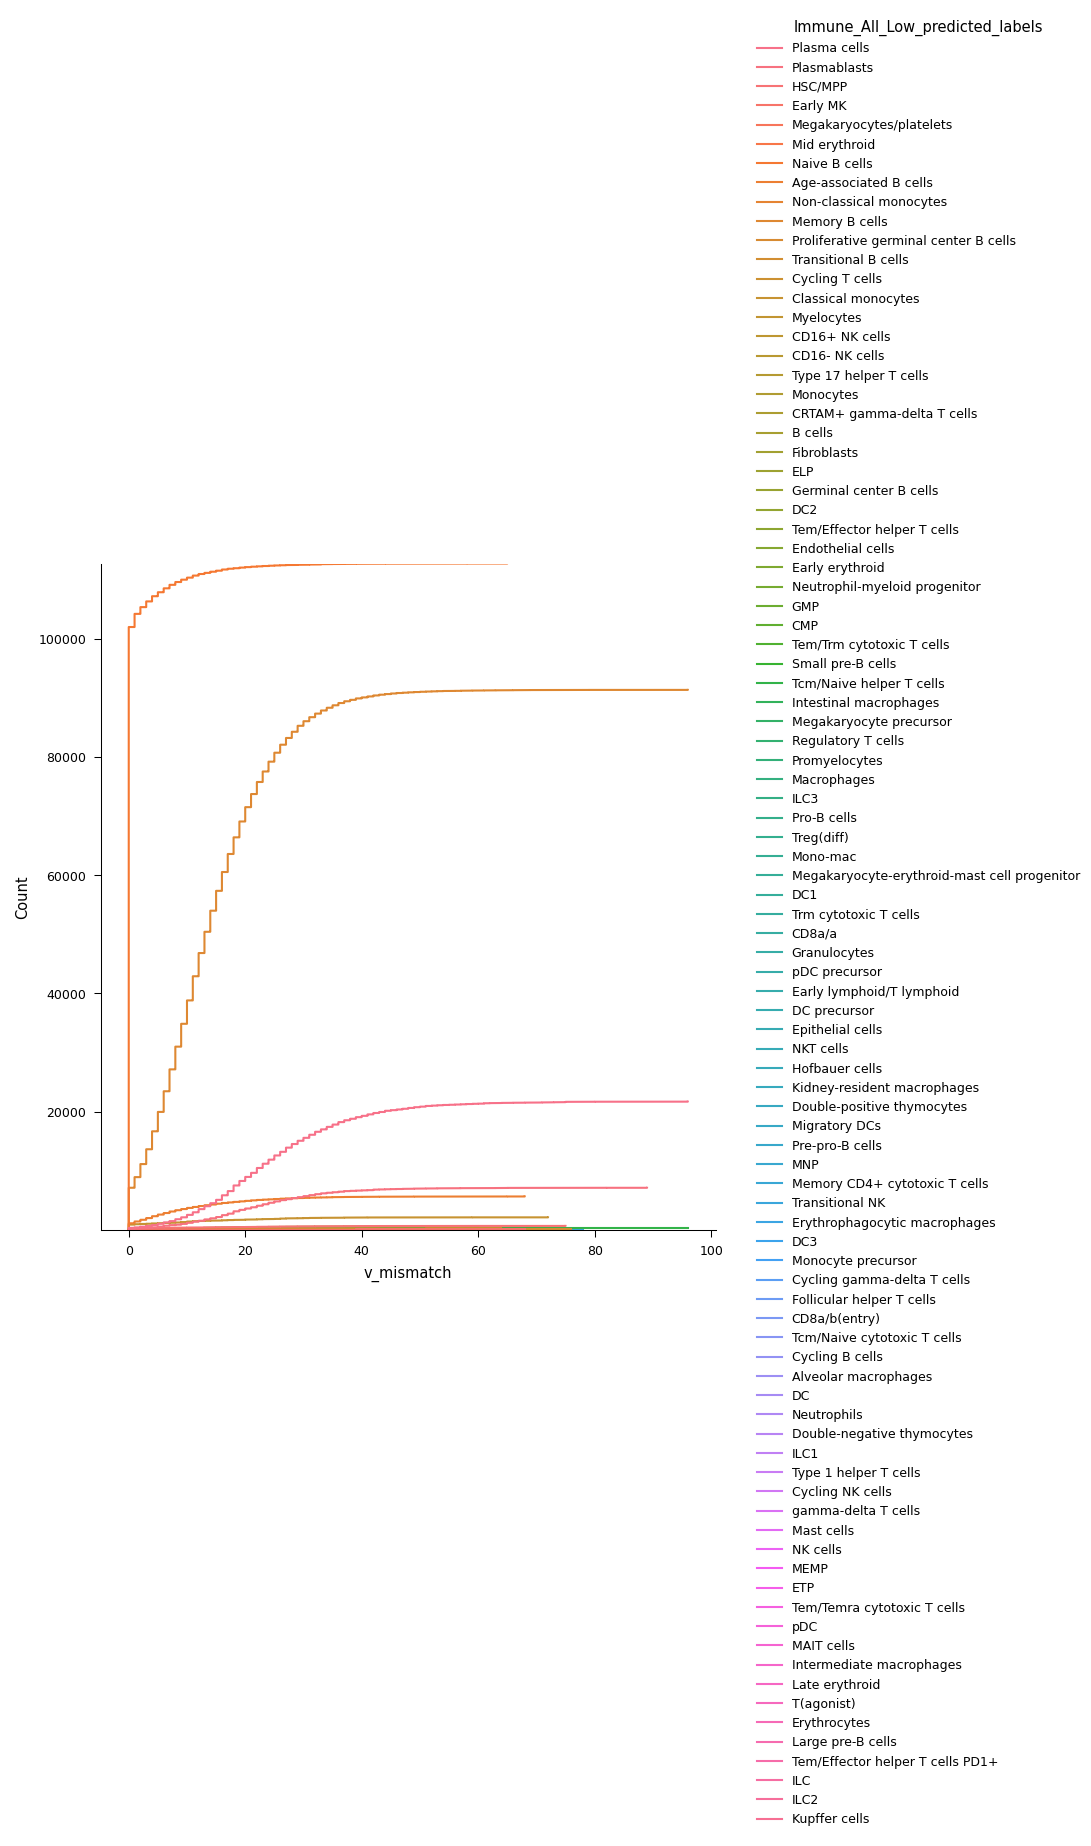

In [83]:
sns.displot(data=df_clean, x = 'v_mismatch', hue = 'Immune_All_Low_predicted_labels', kind="ecdf", stat = 'count')

In [87]:
df_clean = df_clean[~df_clean.Immune_All_Low_predicted_labels.isna()]

TBd6 6472
tissue
LN    33832
PB    13300
SP    10498
BM     6472
Name: count, dtype: int64
permuted_tissue
BM    1719
SP     377
PB     323
LN     315
Name: count, dtype: int64


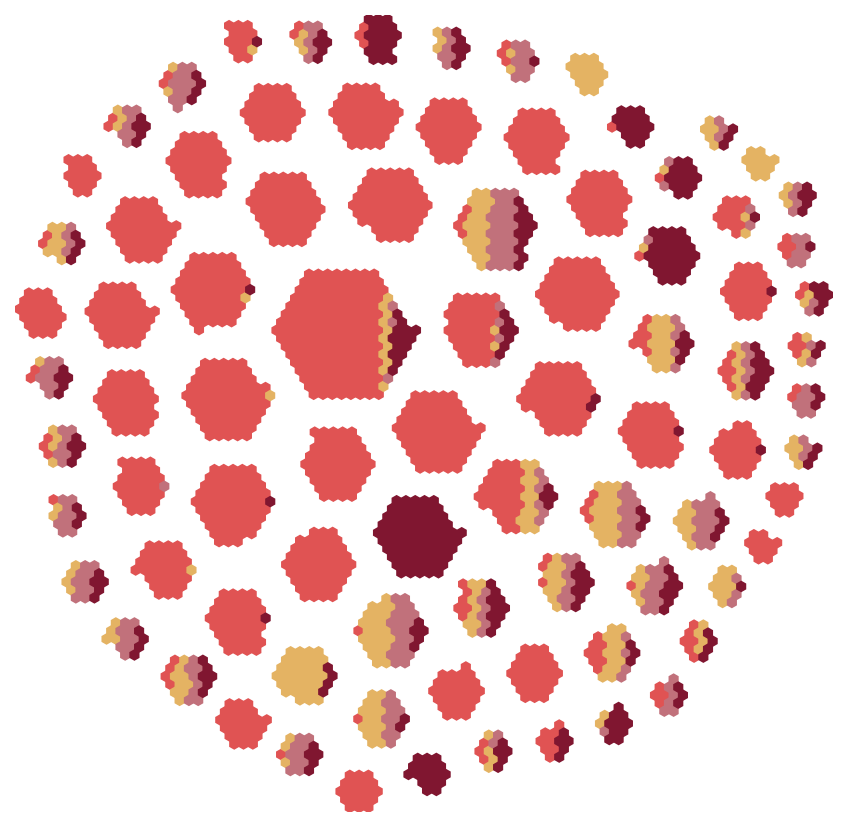

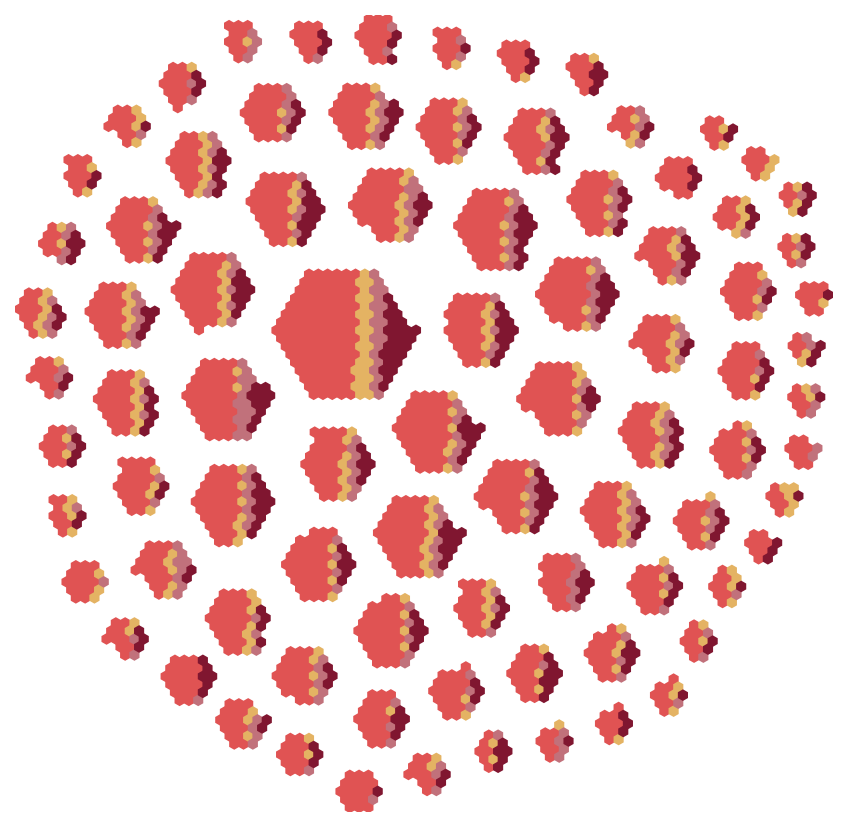

In [89]:
target_donor='TBd6'
ddf = df_clean[(df_clean.donor==target_donor)]
n = ddf.groupby(['tissue']).size().min()
print(target_donor, n)
print(ddf.tissue.value_counts())
ddf = ddf.groupby('tissue').sample(n=n, replace=False).reset_index()
lineage_sizes = ddf.groupby(['donor','lineage_id']).size().to_dict()
ddf['lineage_size'] = ddf.apply(lambda x: lineage_sizes.get((x.donor, x.lineage_id),0),
                                axis=1)
ddf['lineage_size'] = ddf['lineage_size'].astype(str).astype(int)
ddf = ddf[ddf.lineage_size>10]
ddf['permuted_tissue'] = np.random.choice(ddf['tissue'].values,size=ddf.shape[0])
print(ddf.permuted_tissue.value_counts())
fig, ax, new_ddf = plot_hexplot(ddf,
                    group_col='lineage_id',
                    hue='tissue',
                    sort='tissue',
                    cmap=None,
                    palette=tissue_colors)
fig.savefig(f'{FIGURE_OUTDIR}/Figure4a_hexplot.pdf', bbox_inches='tight')

fig, ax, new_ddf = plot_hexplot(ddf[ddf['lineage_size']>2],
                    group_col='lineage_id',
                    hue='permuted_tissue',
                    sort='permuted_tissue',
                    cmap=None,
                    palette=tissue_colors)
fig.savefig(f'{FIGURE_OUTDIR}/Figure4b_hexplot_permuted.pdf', bbox_inches='tight')

In [95]:
celltypes = df_clean.Immune_All_Low_predicted_labels.value_counts().index[:5]
df_clean = df_clean[df_clean.Immune_All_Low_predicted_labels.isin(celltypes)]

In [98]:
df_clean.celltype = df_clean.Immune_All_Low_predicted_labels

/tmp/ipykernel_30327/2086603406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.celltype = df_clean.Immune_All_Low_predicted_labels


In [112]:
ddf.drop_duplicates(subset='vdj_sequence')

,index,sample_uid,cb,vdj_sequence,c_call,n_umis,v_identity,lineage_id,v_mismatch,donor,...,correlation_cycling,cycling,probable_hq_single_b_cell,multiplet_status,is_ambient_source,vdj_is_from_ambient,cb_suid,celltype,lineage_size,permuted_tissue
2,869928,TBd6_fresh_BM,CGTTGGGCATCGTCGG,CAGGTCCGTCTTGTGCAGTCCGGGGCTGAGGTGAAGGAGCCTGGGG...,IGHG2,307.0,83.390,193.0,48.0,TBd6,...,0.003672,False,False,1,0.0,False,CGTTGGGCATCGTCGG_TBd6_fresh_BM,Plasma cells,175,BM
3,876628,TBd6_fresh_BM,CTACGTCAGCGTCAAG,CAGGTGCAGCTGGTGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGG...,IGHA1,125.0,93.898,112617.0,18.0,TBd6,...,-0.090120,False,False,2,0.0,False,CTACGTCAGCGTCAAG_TBd6_fresh_BM,Plasma cells,68,SP
5,897596,TBd6_fresh_BM,TGGACGCAGACGCAAC,GAGGTGCAGCTGGTTGAATCTGGGGGAGGCCTGGTCAAGCCTGGGG...,IGHG1,44.0,92.881,6468.0,20.0,TBd6,...,0.128205,True,False,1,0.0,False,TGGACGCAGACGCAAC_TBd6_fresh_BM,Plasmablasts,39,LN
7,874695,TBd6_fresh_BM,GATCTAGCATGCAATC,CAGGTGCAGCTTATGCAATCTGGGGCTGAGGTGAAGAGGCCTGGGT...,IGHG1,149.0,87.285,837.0,36.0,TBd6,...,-0.061072,False,False,2,0.0,False,GATCTAGCATGCAATC_TBd6_fresh_BM,Plasma cells,58,BM
9,900146,TBd6_fresh_BM,CCACTACAGAACTCGG,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGTGTGGTACGGCCTGGGG...,IGHG2,41.0,93.243,41221.0,20.0,TBd6,...,-0.034692,False,False,1,0.0,False,CCACTACAGAACTCGG_TBd6_fresh_BM,Plasma cells,29,BM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24214,951996,TBd6_fresh_SP,CGATTGATCATCGGAT,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,IGHD,21.0,100.000,260.0,0.0,TBd6,...,-0.016760,False,True,1,0.0,False,CGATTGATCATCGGAT_TBd6_fresh_SP,Naive B cells,29,SP
24220,854154,TBd6_fresh_SP,CGATCGGAGTGTACCT,CAGGTGCAGCTGGTGCAATCTGGGTCTGAGTTGAAGAAGCCTGGGG...,IGHG2,2234.0,89.865,367.0,29.0,TBd6,...,0.567071,True,True,1,0.0,False,CGATCGGAGTGTACCT_TBd6_fresh_SP,Plasmablasts,21,SP
24261,902115,TBd6_fresh_SP,ATCTACTTCCCGACTT,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCAAGCCTGGAG...,IGHM,39.0,100.000,1092.0,0.0,TBd6,...,-0.014869,False,True,1,0.0,False,ATCTACTTCCCGACTT_TBd6_fresh_SP,Naive B cells,11,LN
24309,938965,TBd6_fresh_SP,TTCGAAGCACCTGGTG,CAGGTGCAGCTGGTGGAGTCTGGGGGAGGCGTGGTCCAGCCTGGGA...,IGHM,23.0,100.000,307.0,0.0,TBd6,...,0.027633,True,True,1,0.0,False,TTCGAAGCACCTGGTG_TBd6_fresh_SP,Naive B cells,23,LN


TBd6 4354
tissue
LN    30442
PB    12477
SP     9762
BM     4354
Name: count, dtype: int64
permuted_tissue
BM    83
LN    82
PB    64
SP    59
Name: count, dtype: int64


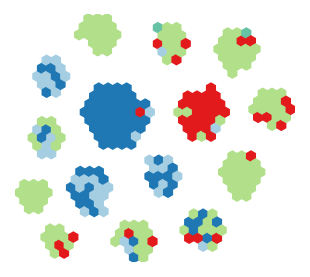

In [115]:
target_donor='TBd6'
ddf = df_clean[(df_clean.donor==target_donor)]
ddf = ddf.drop_duplicates(subset='vdj_sequence')
n = ddf.groupby(['tissue']).size().min()
print(target_donor, n)
print(ddf.tissue.value_counts())
ddf = ddf.groupby('tissue').sample(n=n, replace=False).reset_index()
lineage_sizes = ddf.groupby(['donor','lineage_id']).size().to_dict()
ddf['lineage_size'] = ddf.apply(lambda x: lineage_sizes.get((x.donor, x.lineage_id),0),
                                axis=1)
ddf['lineage_size'] = ddf['lineage_size'].astype(str).astype(int)
ddf = ddf[ddf.lineage_size>10]
ddf['permuted_tissue'] = np.random.choice(ddf['tissue'].values,size=ddf.shape[0])
print(ddf.permuted_tissue.value_counts())
fig, ax, new_ddf = plot_hexplot(ddf,
                    group_col='lineage_id',
                    hue='celltype',
                    sort='tissue',
                    cmap=None,
                    palette=bcelltype_colors_alt)
fig.savefig(f'{FIGURE_OUTDIR}/Figure4a_hexplot.pdf', bbox_inches='tight')

In [110]:
for _, group in ddf.groupby("lineage_id"):
    print(_)
    print(group.celltype.value_counts())

193.0
celltype
Plasma cells              156
Memory B cells             11
Plasmablasts                7
Age-associated B cells      1
Name: count, dtype: int64
206.0
celltype
Memory B cells    33
Naive B cells      2
Name: count, dtype: int64
221.0
celltype
Plasmablasts      24
Plasma cells      18
Memory B cells     1
Naive B cells      1
Name: count, dtype: int64
223.0
celltype
Plasma cells      37
Plasmablasts      30
Memory B cells     4
Name: count, dtype: int64
230.0
celltype
Naive B cells     12
Memory B cells     6
Plasma cells       3
Plasmablasts       2
Name: count, dtype: int64
244.0
celltype
Plasma cells              25
Plasmablasts              24
Memory B cells             5
Age-associated B cells     2
Name: count, dtype: int64
246.0
celltype
Plasmablasts      14
Plasma cells       5
Memory B cells     2
Name: count, dtype: int64
248.0
celltype
Plasmablasts      10
Plasma cells       8
Memory B cells     2
Name: count, dtype: int64
253.0
celltype
Naive B cells     10
P

In [31]:
leiden_colors = {'#ffff00': '0',
 '#1ce6ff': '1',
 '#ff34ff': '2',
 '#ff4a46': '3',
 '#008941': '4',
 '#006fa6': '5',
 '#a30059': '6',
 '#ffdbe5': '7',
 '#7a4900': '8',
 '#0000a6': '9',
 '#63ffac': '10',
 '#b79762': '11',
 '#004d43': '12',
 '#8fb0ff': '13',
 '#997d87': '14',
 '#5a0007': '15',
 '#809693': '16',
 '#6a3a4c': '17',
 '#1b4400': '18',
 '#4fc601': '19',
 '#3b5dff': '20',
 '#4a3b53': '21',
 '#ff2f80': '22',
 '#61615a': '23',
 '#ba0900': '24',
 '#6b7900': '25',
 '#00c2a0': '26',
 '#ffaa92': '27',
 '#ff90c9': '28',
 '#b903aa': '29',
 '#d16100': '30',
 '#ddefff': '31',
 '#000035': '32',
 '#7b4f4b': '33',
 '#a1c299': '34',
 '#300018': '35',
 '#0aa6d8': '36',
 '#013349': '37',
 '#00846f': '38',
 '#372101': '39',
 '#ffb500': '40',
 '#c2ffed': '41', 
 '#FFFFFF': "over"}
leiden_colors = {v: k for k, v in leiden_colors.items()}

In [34]:
## Celltypes
df_clean.loc[:,"celltype"] = df_clean.celltype.fillna("over")

/tmp/ipykernel_30327/2094881024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.celltype = df_clean.celltype.fillna("over")


In [47]:
df_clean.celltype = df_clean.celltype.astype(str)

/tmp/ipykernel_30327/1057224328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.celltype = df_clean.celltype.astype(str)


In [50]:
df_clean.celltype = df_clean.celltype.str.replace(".0", "")

/tmp/ipykernel_30327/276505395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.celltype = df_clean.celltype.str.replace(".0", "")


In [74]:
celltypist_colors = {'Age-associated B cells': '#ffff00',
 'Alveolar macrophages': '#1ce6ff',
 'B cells': '#ff34ff',
 'CD8a/a': '#ff4a46',
 'CD8a/b(entry)': '#008941',
 'CD16+ NK cells': '#006fa6',
 'CD16- NK cells': '#a30059',
 'CMP': '#ffdbe5',
 'CRTAM+ gamma-delta T cells': '#7a4900',
 'Classical monocytes': '#0000a6',
 'Cycling B cells': '#63ffac',
 'Cycling NK cells': '#b79762',
 'Cycling T cells': '#004d43',
 'Cycling gamma-delta T cells': '#8fb0ff',
 'Cycling monocytes': '#997d87',
 'DC': '#5a0007',
 'DC1': '#809693',
 'DC2': '#6a3a4c',
 'DC3': '#1b4400',
 'DC precursor': '#4fc601',
 'Double-negative thymocytes': '#3b5dff',
 'Double-positive thymocytes': '#4a3b53',
 'ELP': '#ff2f80',
 'ETP': '#61615a',
 'Early MK': '#ba0900',
 'Early erythroid': '#6b7900',
 'Early lymphoid/T lymphoid': '#00c2a0',
 'Endothelial cells': '#ffaa92',
 'Epithelial cells': '#ff90c9',
 'Erythrocytes': '#b903aa',
 'Erythrophagocytic macrophages': '#d16100',
 'Fibroblasts': '#ddefff',
 'Follicular B cells': '#000035',
 'Follicular helper T cells': '#7b4f4b',
 'GMP': '#a1c299',
 'Germinal center B cells': '#300018',
 'Granulocytes': '#0aa6d8',
 'HSC/MPP': '#013349',
 'Hofbauer cells': '#00846f',
 'ILC': '#372101',
 'ILC1': '#ffb500',
 'ILC2': '#c2ffed',
 'ILC3': '#a079bf',
 'Intermediate macrophages': '#cc0744',
 'Intestinal macrophages': '#c0b9b2',
 'Kidney-resident macrophages': '#c2ff99',
 'Kupffer cells': '#001e09',
 'Large pre-B cells': '#00489c',
 'Late erythroid': '#6f0062',
 'MAIT cells': '#0cbd66',
 'MEMP': '#eec3ff',
 'MNP': '#456d75',
 'Macrophages': '#b77b68',
 'Mast cells': '#7a87a1',
 'Megakaryocyte precursor': '#788d66',
 'Megakaryocyte-erythroid-mast cell progenitor': '#885578',
 'Megakaryocytes/platelets': '#fad09f',
 'Memory B cells': '#ff8a9a',
 'Memory CD4+ cytotoxic T cells': '#d157a0',
 'Mid erythroid': '#bec459',
 'Migratory DCs': '#456648',
 'Mono-mac': '#0086ed',
 'Monocyte precursor': '#886f4c',
 'Monocytes': '#34362d',
 'Myelocytes': '#b4a8bd',
 'NK cells': '#00a6aa',
 'NKT cells': '#452c2c',
 'Naive B cells': '#636375',
 'Neutrophil-myeloid progenitor': '#a3c8c9',
 'Neutrophils': '#ff913f',
 'Non-classical monocytes': '#938a81',
 'Plasma cells': '#575329',
 'Plasmablasts': '#00fecf',
 'Pre-pro-B cells': '#b05b6f',
 'Pro-B cells': '#8cd0ff',
 'Proliferative germinal center B cells': '#3b9700',
 'Promyelocytes': '#04f757',
 'Regulatory T cells': '#c8a1a1',
 'Small pre-B cells': '#1e6e00',
 'T(agonist)': '#7900d7',
 'Tcm/Naive cytotoxic T cells': '#a77500',
 'Tcm/Naive helper T cells': '#6367a9',
 'Tem/Effector helper T cells': '#a05837',
 'Tem/Effector helper T cells PD1+': '#6b002c',
 'Tem/Temra cytotoxic T cells': '#772600',
 'Tem/Trm cytotoxic T cells': '#d790ff',
 'Transitional B cells': '#9b9700',
 'Transitional DC': '#549e79',
 'Transitional NK': '#fff69f',
 'Treg(diff)': '#201625',
 'Trm cytotoxic T cells': '#72418f',
 'Type 1 helper T cells': '#bc23ff',
 'Type 17 helper T cells': '#99adc0',
 'gamma-delta T cells': '#3a2465',
 'pDC': '#922329',
 'pDC precursor': '#5b4534',
 'over':"#FFFFFF"}

In [75]:
df_clean.loc[:,'celltypist'] = df_clean['Immune_All_Low_predicted_labels']

## Celltypes

df_clean.loc[:,"celltypist"] = df_clean.celltypist.fillna("over")

In [7]:
def overlay_hexplots(data_frame1,
                     fig_ax=None,
                     group_col='lineage_id',
                     sort=None,
                     hue=None,
                     palette={},
                     r1=2,
                     r2=1,  # Radius for the second plot
                     pad=1,
                     max_colors=10,
                     cmap=None,
                     small_hex_col=None,  # New argument for column to use for coloring smaller hexes
                     small_hex_palette={}  # New argument for palette for smaller hexes
                    ):
    
    # Plot the first set of hexagons and get their coordinates
    fig, ax, df_with_coords = plot_hexplot(data_frame1,
                                           fig_ax=fig_ax,
                                           group_col=group_col,
                                           sort=sort,
                                           hue=hue,
                                           palette=palette,
                                           r=r1,
                                           pad=pad,
                                           max_colors=max_colors,
                                           cmap=cmap)
    
    # Use the same coordinates for the second set of hexagons, but change the radius to r2
    df_with_coords['r'] = r2
    
    # If small_hex_col is provided, use it to determine colors for smaller hexes
    if small_hex_col:
        df_with_coords['small_hex_color'] = df_with_coords[small_hex_col].map(small_hex_palette)
    
    # Plot the second set of hexagons (smaller, color based on small_hex_col if provided)
    for idx, row in df_with_coords.iterrows():
        color = row.get('small_hex_color', 'white')  # Use white as default color
        patch = patches.CirclePolygon(
            (row['x'], row['y']),
            row['r'], resolution=6,
            color=color,
            alpha=1
        )
        ax.add_patch(patch)
    
    # Return the figure and axis
    return fig, ax

In [8]:
ddf.dropna(subset='celltype')

,index,sample_uid,cb,vdj_sequence,c_call,n_umis,v_identity,lineage_id,v_mismatch,donor,...,cycling,probable_hq_single_b_cell,multiplet_status,is_ambient_source,vdj_is_from_ambient,cb_suid,ASC_subtype,celltype,lineage_size,permuted_tissue
20,882782,TBd6_fresh_BM,ATCTGCCTCAAGGCTT,CAGCTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,IGHA1,87.0,94.983,11908.0,15.0,TBd6,...,True,False,1,0.0,False,ATCTGCCTCAAGGCTT_TBd6_fresh_BM,NaN,Naive B cells,103,SP
24,980498,TBd6_fresh_BM,TACCTTACAGCCTTGG,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,IGHM,16.0,100.000,1174.0,0.0,TBd6,...,False,True,1,0.0,False,TACCTTACAGCCTTGG_TBd6_fresh_BM,NaN,Naive B cells,17,BM
44,994921,TBd6_fresh_BM,GAGGTGATCCTAGTGA,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGCCTGGGG...,IGHM,14.0,100.000,1144.0,0.0,TBd6,...,False,True,1,0.0,False,GAGGTGATCCTAGTGA_TBd6_fresh_BM,NaN,Naive B cells,19,BM
48,913168,TBd6_fresh_BM,ATCTGCCGTTAAAGTG,GAGGTGCACCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGG...,IGHA1,32.0,90.970,15206.0,27.0,TBd6,...,False,False,1,0.0,False,ATCTGCCGTTAAAGTG_TBd6_fresh_BM,NaN,ASCs,48,BM
51,878156,TBd6_fresh_BM,GTACTTTCAATGGACG,GAGGTGCACCTGGTGGAGTCTGGGGGAGGCTTCGTACAGCCTGGGG...,IGHA1,132.0,84.797,591.0,44.0,TBd6,...,False,False,1,0.0,False,GTACTTTCAATGGACG_TBd6_fresh_BM,NaN,ASCs,114,PB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170772,854964,TBd6_fresh_SP,TTCGAAGCAGGTCCAC,GAGGTGCAGCTGTTGGAGTCTGGGGGAGGCCTGGTTCAGCCGGGGG...,IGHA1,2067.0,88.055,1133.0,34.0,TBd6,...,False,False,1,0.0,False,TTCGAAGCAGGTCCAC_TBd6_fresh_SP,NaN,ASCs,35,BM
170778,895010,TBd6_fresh_SP,GCTGCGATCAGTTGAC,CAGGTGCAGTTACAGGAGTCGGGCCCAAGACTGCTGAAGCCTTCGG...,IGHG2,7.0,85.666,851.0,42.0,TBd6,...,True,False,2,0.0,False,GCTGCGATCAGTTGAC_TBd6_fresh_SP,NaN,Naive B cells,128,PB
170809,994789,TBd6_fresh_SP,CCACGGACAGACAGGT,GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTACAGCCGGGGG...,IGHM,14.0,95.904,7304.0,12.0,TBd6,...,False,True,1,0.0,False,CCACGGACAGACAGGT_TBd6_fresh_SP,NaN,Memory B cells,8,PB
170814,961091,TBd6_fresh_SP,GTCTCGTTCCGGGTGT,GAGATGCAGCTGTTGGAGTCTGGGGGAGGCTTGGTACAGTCTGGGG...,IGHM,19.0,92.568,328.0,22.0,TBd6,...,False,True,1,0.0,False,GTCTCGTTCCGGGTGT_TBd6_fresh_SP,NaN,Memory B cells,125,BM


In [9]:
ddf.dropna(subset = 'celltype')

ddf['celltype_simple'] = ddf['celltype'].str.replace("-1|-2|-3|-4", "s", regex=True)

In [10]:
ddf.dropna(subset='celltype').celltype_simple.value_counts()

celltype_simple
ASCs                          4158
Naive B cells                 2166
Memory B cells                 822
Promyelocytes                  116
ABCs                            55
                              ... 
MEMP                             1
Mono-mac                         1
Intermediate macrophages         1
Mast cells                       1
Double-negative thymocytes       1
Name: count, Length: 55, dtype: int64

In [11]:
nona_ddf = ddf.dropna(subset='celltype')

In [12]:
nona_ddf = nona_ddf[nona_ddf.celltype_simple.str.contains("B cells|ASCs", regex=True)]

In [13]:
nona_ddf.celltype_simple.value_counts()

celltype_simple
ASCs               4158
Naive B cells      2166
Memory B cells      822
GC B cells           12
Cycling B cells       1
Name: count, dtype: int64

In [14]:
bcelltype_colors_alt

{'Plasmablasts': '#a6cee3',
 'Plasma cells': '#1f78b4',
 'Naive B cells': '#b2df8a',
 'GC B cells': '#33a02c',
 'ABCs': '#fb9a99',
 'Memory B cells': '#e31a1c',
 'ASC-1': '#A6CEE3',
 'ASC-2': '#4598C4',
 'ASC-3': '#1B699D',
 'ASC-4': '#7071A3',
 'ASCs': '#1f78b4',
 'B cells': '#e31a1c',
 'Pro-B cells': '#FFFFFF',
 'Cycling B cells': '#FFFFFF'}

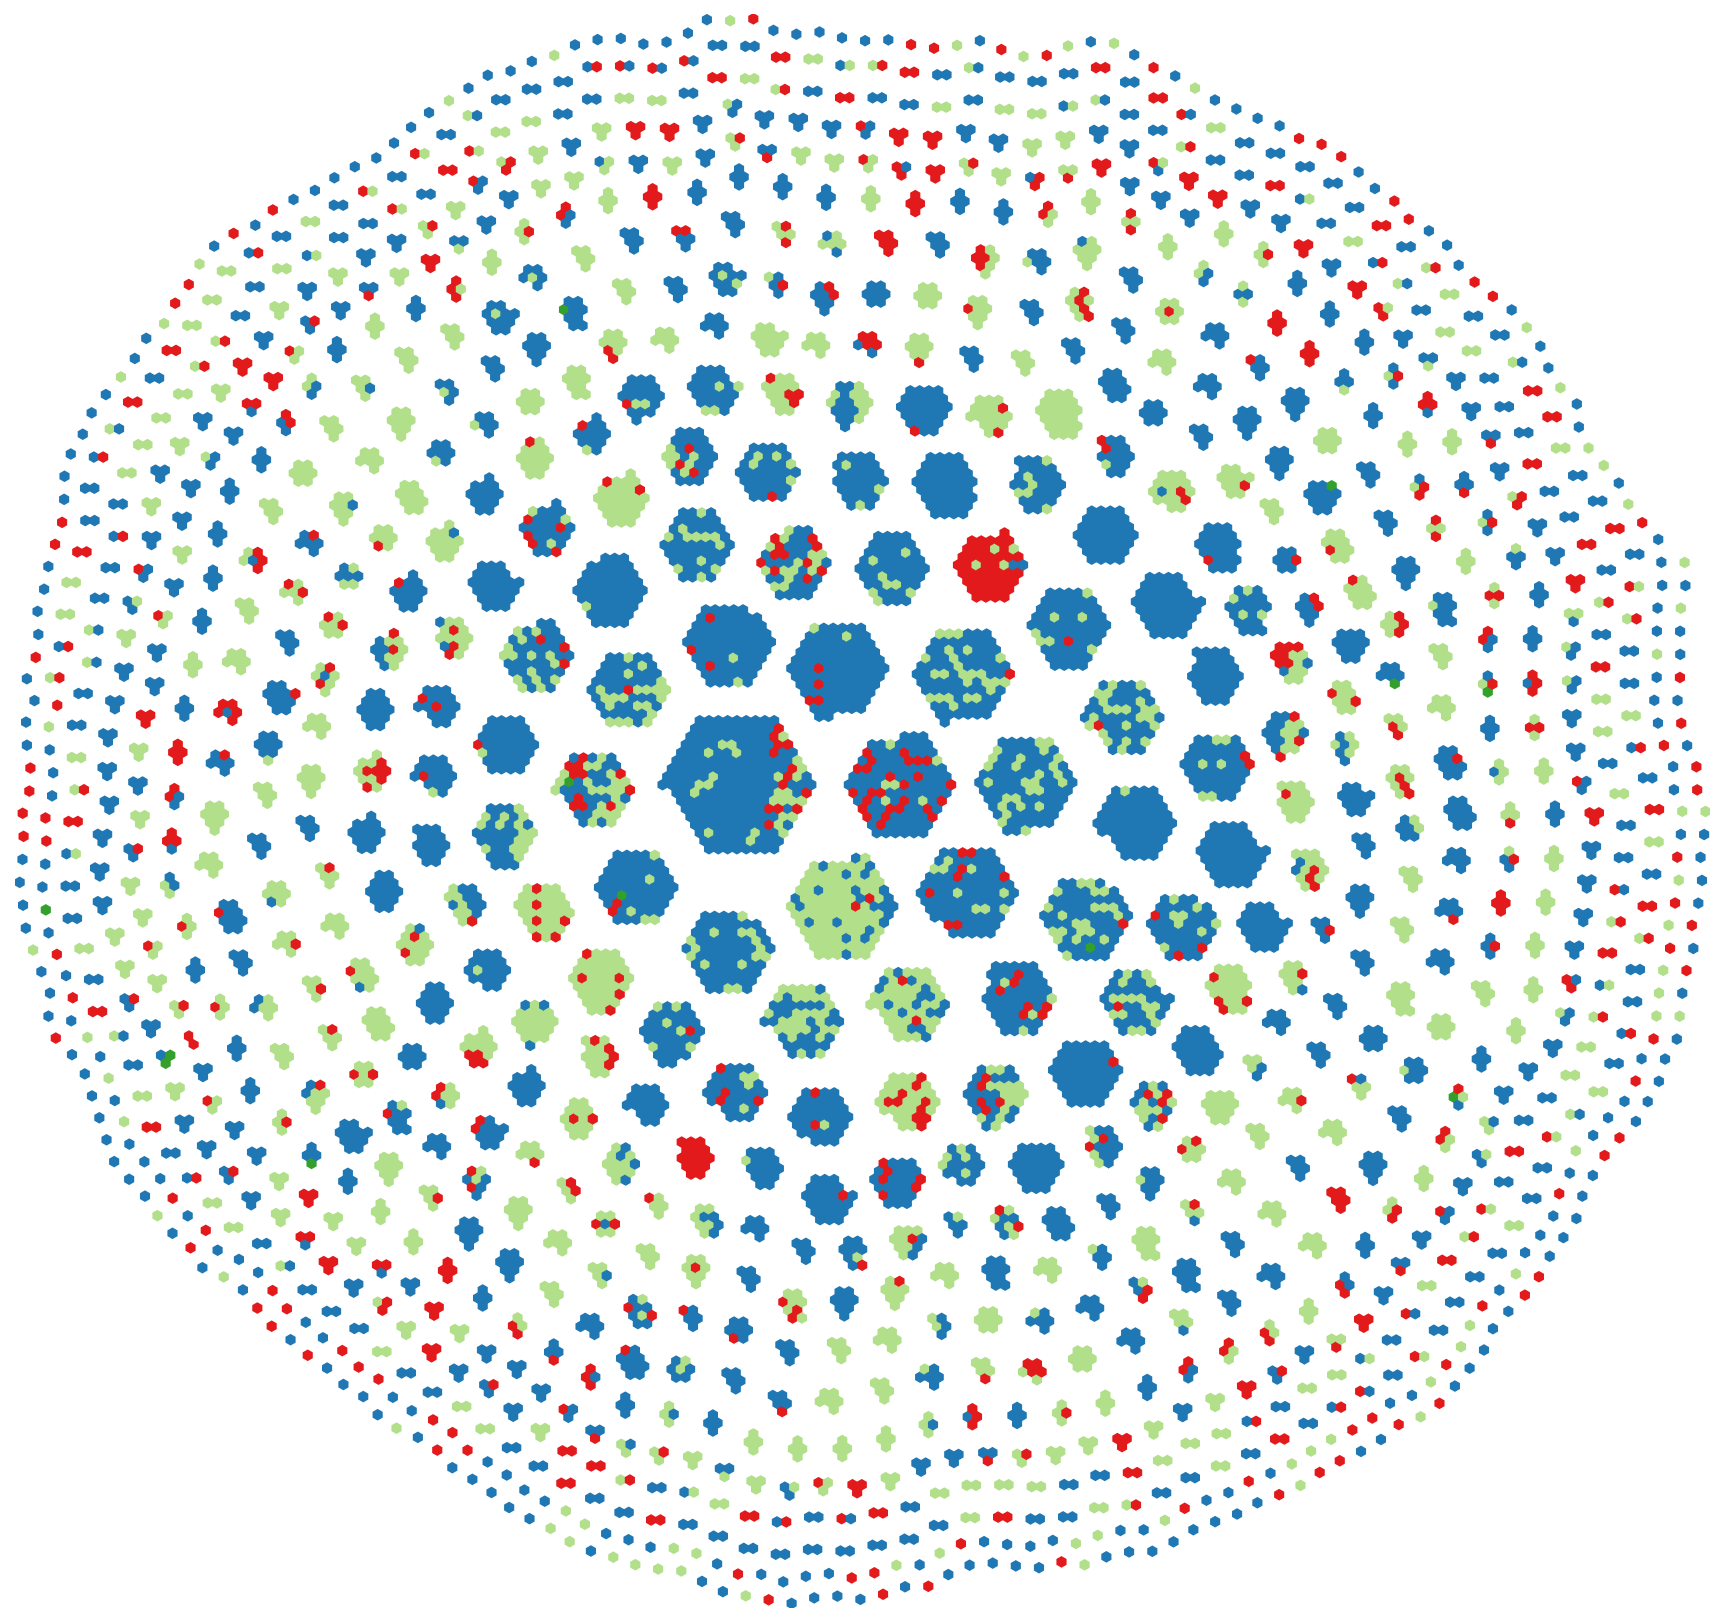

In [15]:
fig, ax, new_ddf = plot_hexplot(nona_ddf,
                    group_col='lineage_id',
                    hue='celltype_simple',
                    sort='tissue',
                    cmap=None,
                    palette=bcelltype_colors_alt)

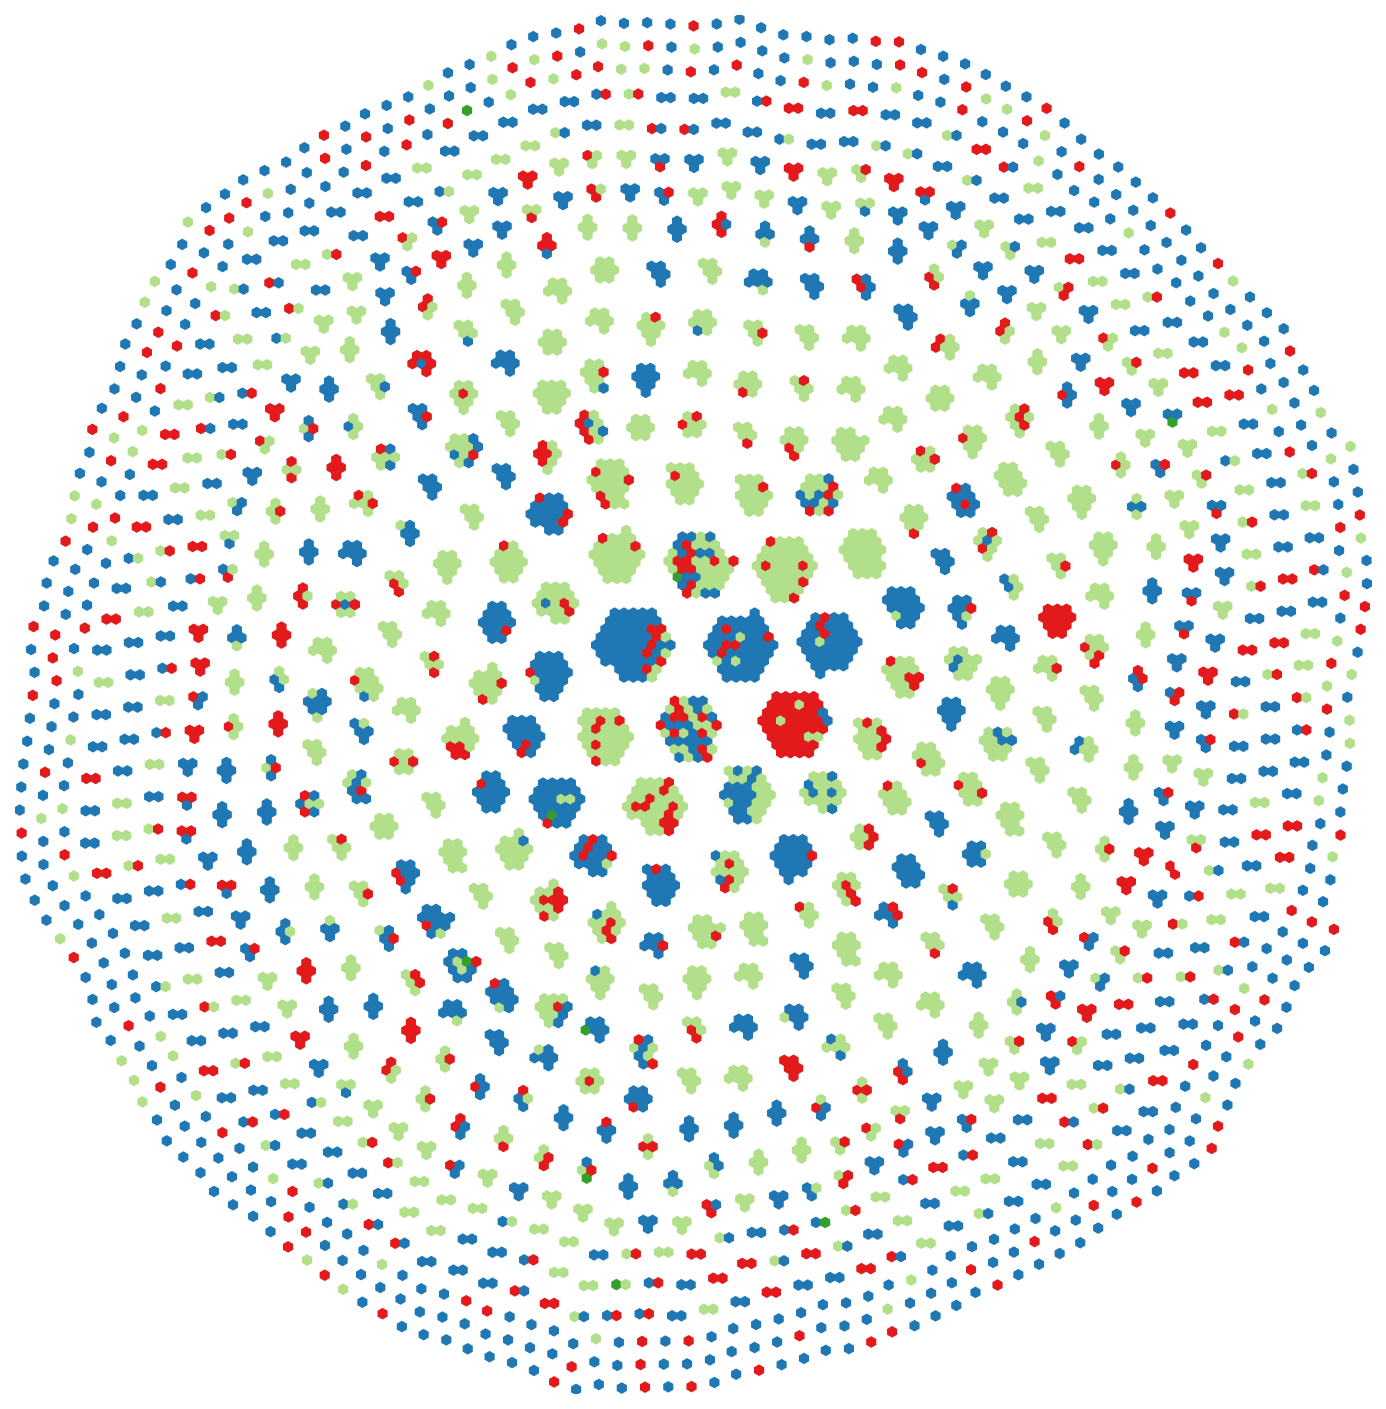

In [16]:
fig, ax, new_ddf = plot_hexplot(nona_ddf.drop_duplicates(subset='vdj_sequence'),
                    group_col='lineage_id',
                    hue='celltype_simple',
                    sort='tissue',
                    cmap=None,
                    palette=bcelltype_colors_alt)

In [17]:
def overlay_hexplots(data_frame1, 
                     fig_ax=None,
                     group_col='lineage_id',
                     sort=tissue,
                     hue=None,
                     palette={},
                     r1=2, 
                     r2=1,  # Radius for the second plot
                     pad=1,
                     max_colors=10,
                     cmap=None):
    
    # Plot the first set of hexagons and get their coordinates
    fig, ax, df_with_coords = plot_hexplot(data_frame1, 
                                           fig_ax=fig_ax, 
                                           group_col=group_col,
                                           sort=sort,
                                           hue=hue,
                                           palette=palette,
                                           r=r1,
                                           pad=pad,
                                           max_colors=max_colors,
                                           cmap=cmap)
    
    # Use the same coordinates for the second set of hexagons, but change the radius to r2
    df_with_coords['r'] = r2
    
    # Plot the second set of hexagons (smaller and white)
    for idx, row in df_with_coords.iterrows():
        patch = patches.CirclePolygon(
            (row['x'], row['y']),
            row['r'], resolution=6,
            color='white',
            alpha=1
        )
        ax.add_patch(patch)
    
    # Return the figure and axis
    return fig, ax


NameError: name 'tissue' is not defined

In [ ]:
ddf['celltype_simple'] = ddf['celltype'].str.replace("-1|-2|-3|-4", "s", regex=True)

In [ ]:
ddf.celltype_simple.value_counts()

celltype_simple
ASCs               959
Naive B cells      521
Memory B cells     185
ABCs                12
Cycling B cells      1
Name: count, dtype: int64

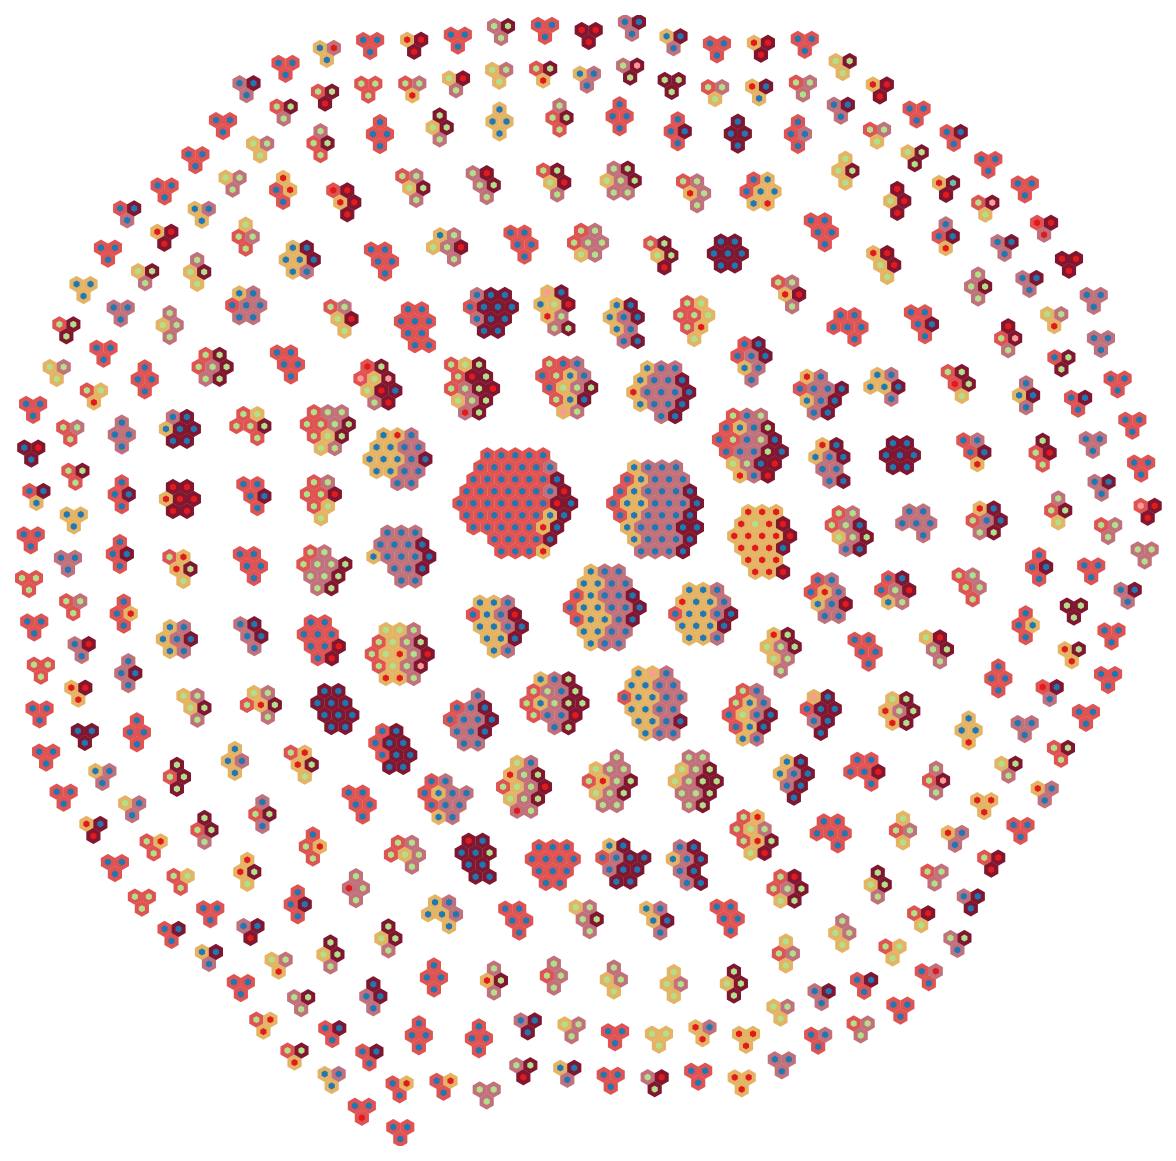

In [ ]:
# Assuming df1 is your data frame for the first set of hexes
fig, ax = overlay_hexplots(ddf, r1=3, r2=1, hue = 'tissue', sort = 'tissue', palette=tissue_colors, small_hex_col='celltype_simple', small_hex_palette=bcelltype_colors_alt)
plt.show()


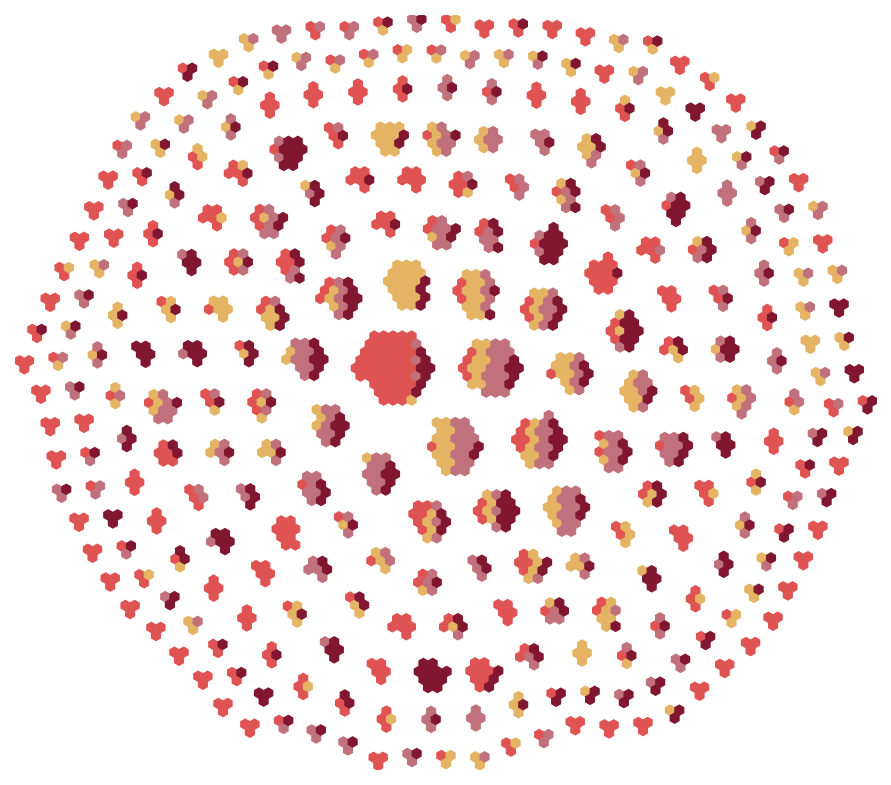

In [ ]:
fig, ax, new_ddf = plot_hexplot(ddf,
                    group_col='lineage_id',
                    hue='tissue',
                    sort='tissue',
                    cmap=None,
                    palette=tissue_colors)